#### imports

In [38]:
import pandas as pd
import networkx as nx
import numpy as np
from networkx.algorithms import bipartite
import matplotlib.pyplot as plt
import matplotlib as mpl
import itertools
from copy import deepcopy
from scipy.integrate import solve_ivp
from itertools import combinations_with_replacement
from emn_model import (
    get_clean_dataset, generate_bipartite_network, diffusion_dynamics, tree_project_network
)

#### Visualization

In [39]:
TEX_PLOTS = True

# # Plotting config
# if TEX_PLOTS:
#     plt.rc("text", usetex=True)
#     plt.rc("font", family="serif")
#     plt.rc("text.latex", preamble=r"""
#          \usepackage{times}
#          \usepackage{mathptmx}
#          \usepackage{siunitx}""")
# else:
#     plt.rc("text", usetex=False)

# mpl.rcParams["figure.dpi"] = 200
# mpl.rcParams["legend.fontsize"] = 14
# mpl.rcParams["font.size"] = 14
# mpl.rcParams["axes.labelsize"] = mpl.rcParams["axes.titlesize"] = 16
# mpl.rcParams["axes.grid"] = True
# mpl.rcParams["grid.alpha"] = 0.2
# mpl.rcParams["axes.axisbelow"] = True
# mpl.rcParams["lines.linewidth"] = 1

# cmap = mpl.cm.get_cmap("Dark2")
# mpl.rcParams["axes.prop_cycle"] = mpl.cycler(color=cmap.colors)

np.random.seed(1231)

# Results Barabasi Scale-Free network

### Initialization of the network.

In [78]:
from forest_generator import generate_barabasi_forest

G= generate_barabasi_forest(54, 9)

graph has average degree of  15.0
graph has average shortest path length of  1.7281621243885394


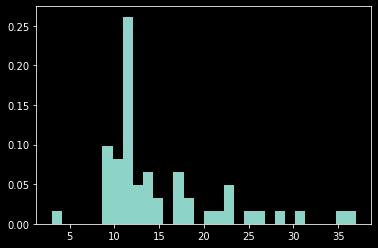

In [79]:
degrees = [v for k,v in G.degree()]
_ = plt.hist(degrees, bins=30, density=True)
print(f"graph has average degree of ", np.mean(degrees))
print(f"graph has average shortest path length of ", nx.average_shortest_path_length(G))


In [80]:
N = len(G.nodes)

plant_carbon_0 = np.array(list(nx.get_node_attributes(G, "carbon_value").values()))
root_carbon_0 = 0.1 * plant_carbon_0
plant_diameter_0 = np.array(list(nx.get_node_attributes(G, "diameter").values()))

t_range = (0, 16_000)
D_C = 5.0e-4 # carbon diffusion coeff
uptake_ps = (0.55, 0.0, 55.0)
f = 5.0e-4 # sensitive w.r.t plant carbon deposition
k = 0.6
g = 0.004
c = 0.82
rho = 0.01

sol = solve_ivp(diffusion_dynamics, t_range, np.concatenate([root_carbon_0, plant_carbon_0, plant_diameter_0]),
                args=(G, D_C, N, uptake_ps, f, k, c, g, rho), dense_output=True, method="BDF")

time_steps = 300
t = np.linspace(t_range[0], t_range[1], time_steps)
z = sol.sol(t)

#Rename the quantities of interest
roots_carbon, plant_carbon, plant_diameter = z[:N, :], z[N:2*N, :], z[2*N:3*N, :] 

In [81]:
nodes_by_cohort = {"Sapling": [], "Maturing": [], "Established": []}
node_list = list(G.nodes)

for node in G.nodes:
    nodes_by_cohort[G.nodes[node]["cohort"]].append(node)

### Group information

In [86]:
success_threshold = 5

Cohort Sapling grew on average 1.91 cm
Cohort Sapling grew on average 161.92% +- 63.88

 #### Sapling statistics #######
Sapling competition between samplings (std growth percentage) 63.88%
0 out of the 35 Saplings were successful. That is 0.00%


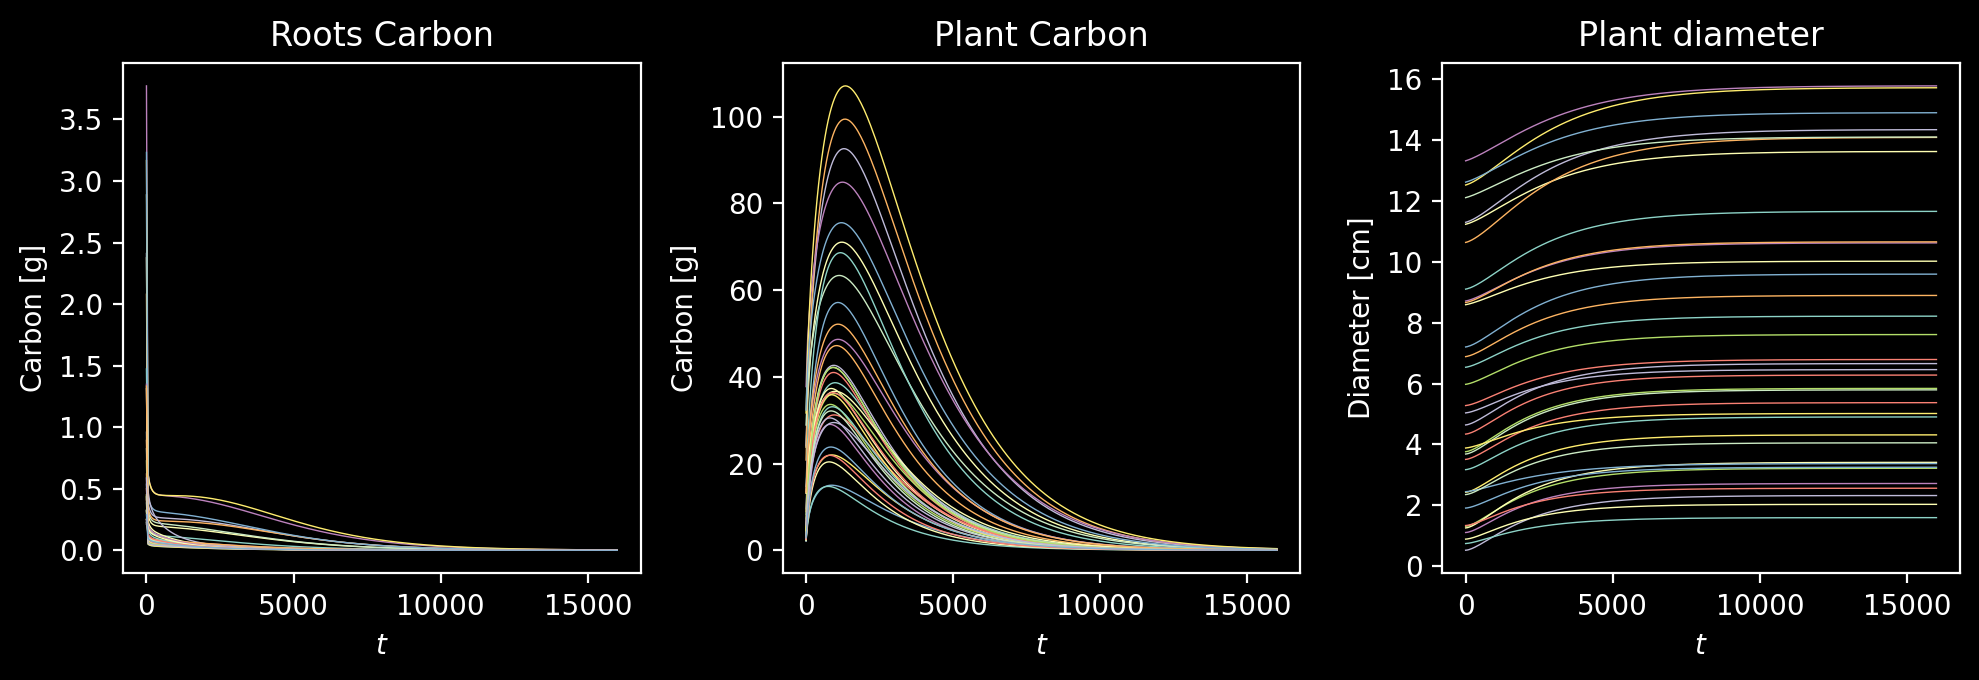

Cohort Maturing grew on average 1.64 cm
Cohort Maturing grew on average 109.01% +- 5.17


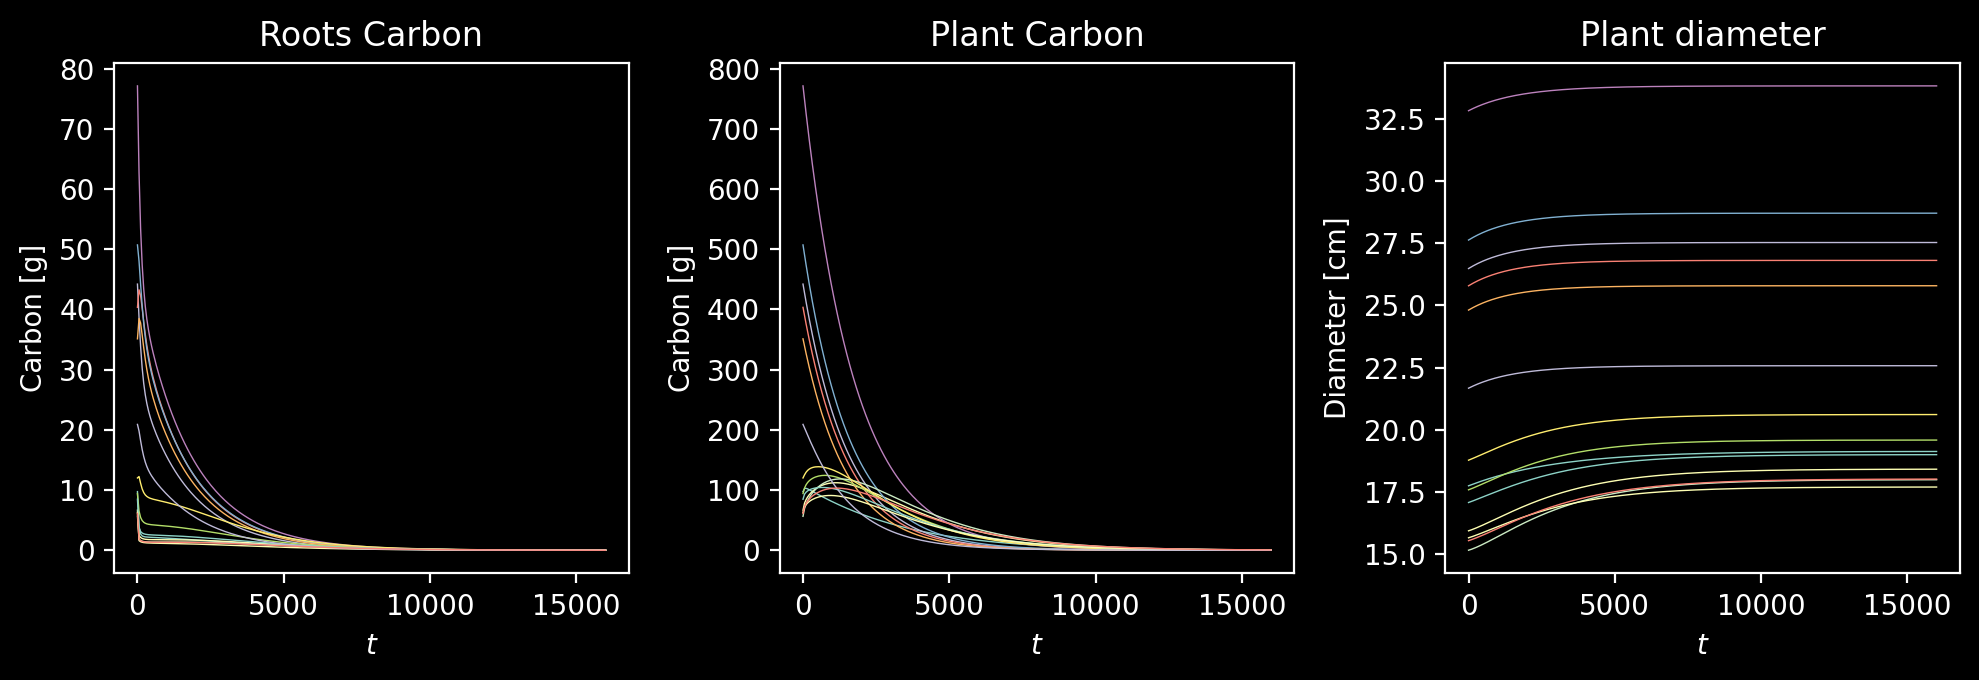

Cohort Established grew on average 0.48 cm
Cohort Established grew on average 101.26% +- 0.92


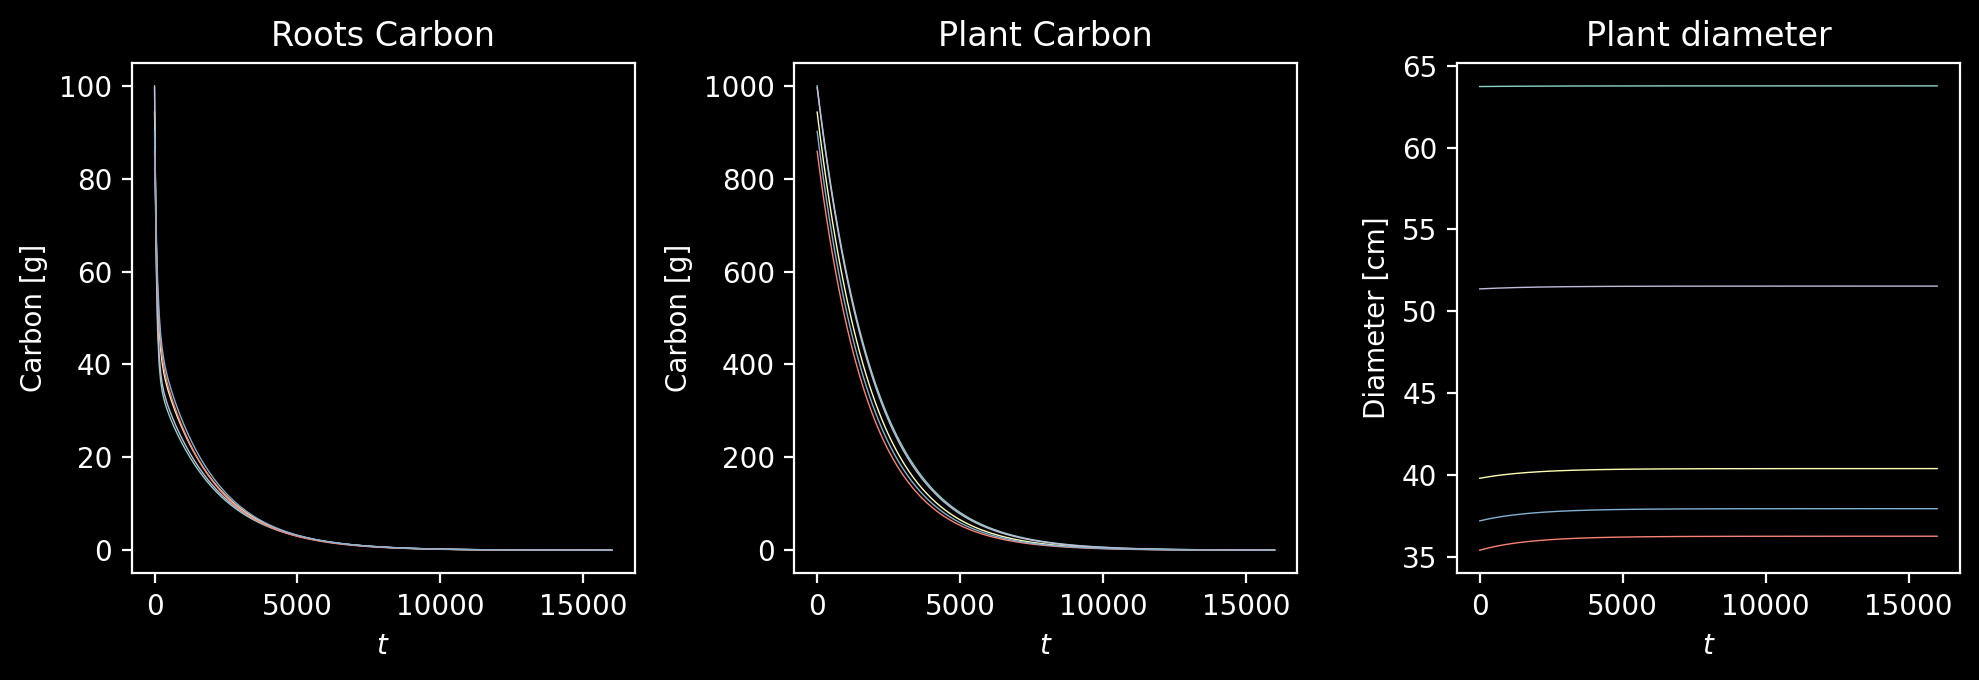

In [87]:
for cohort, nodes in nodes_by_cohort.items():
    
    node_idxs = [node_list.index(node) for node in nodes]
    
    #Calculate Average growth
    growth = plant_diameter[node_idxs, -1] - plant_diameter[node_idxs, 0]
    avg_growth = np.mean(growth)
    
    #Calculate growth in percantages
    percentages = plant_diameter[node_idxs, -1]/plant_diameter[node_idxs, 0]*100
    percentage_mean = np.mean(percentages)
    percentage_stdev = np.std(percentages)


    print(f"Cohort {str(cohort)} grew on average {avg_growth:.2f} cm")
    print(f"Cohort {str(cohort)} grew on average {percentage_mean:.2f}% +- {percentage_stdev:.2f}")
    
    if cohort == "Sapling": 
        n_successes =  np.sum([growth >= success_threshold])     #np.sum([percentages >= 200])
                
        print("\n #### Sapling statistics #######")
        print(f"Sapling competition between samplings (std growth percentage) {percentage_stdev:.2f}%")
        print(f"{n_successes} out of the {len(percentages)} Saplings were successful. That is {n_successes/len(percentages)*100:.2f}%")

        
    #print(percentages)

    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 3.5), dpi=200)

    axes[0].set_title("Roots Carbon")
    axes[0].plot(t, roots_carbon[node_idxs, :].T, linewidth=0.5)
    axes[0].set_xlabel("$t$")
    axes[0].set_ylabel("Carbon [g]")

    axes[1].set_title("Plant Carbon")
    axes[1].plot(t, plant_carbon[node_idxs, :].T, linewidth=0.5)
    axes[1].set_xlabel("$t$")
    axes[1].set_ylabel("Carbon [g]")

    axes[2].set_title("Plant diameter")
    axes[2].plot(t, plant_diameter[node_idxs, :].T, linewidth=0.5)
    axes[2].set_xlabel("$t$")
    axes[2].set_ylabel("Diameter [cm]")

    plt.tight_layout()
    plt.show()

### Nutrient flows

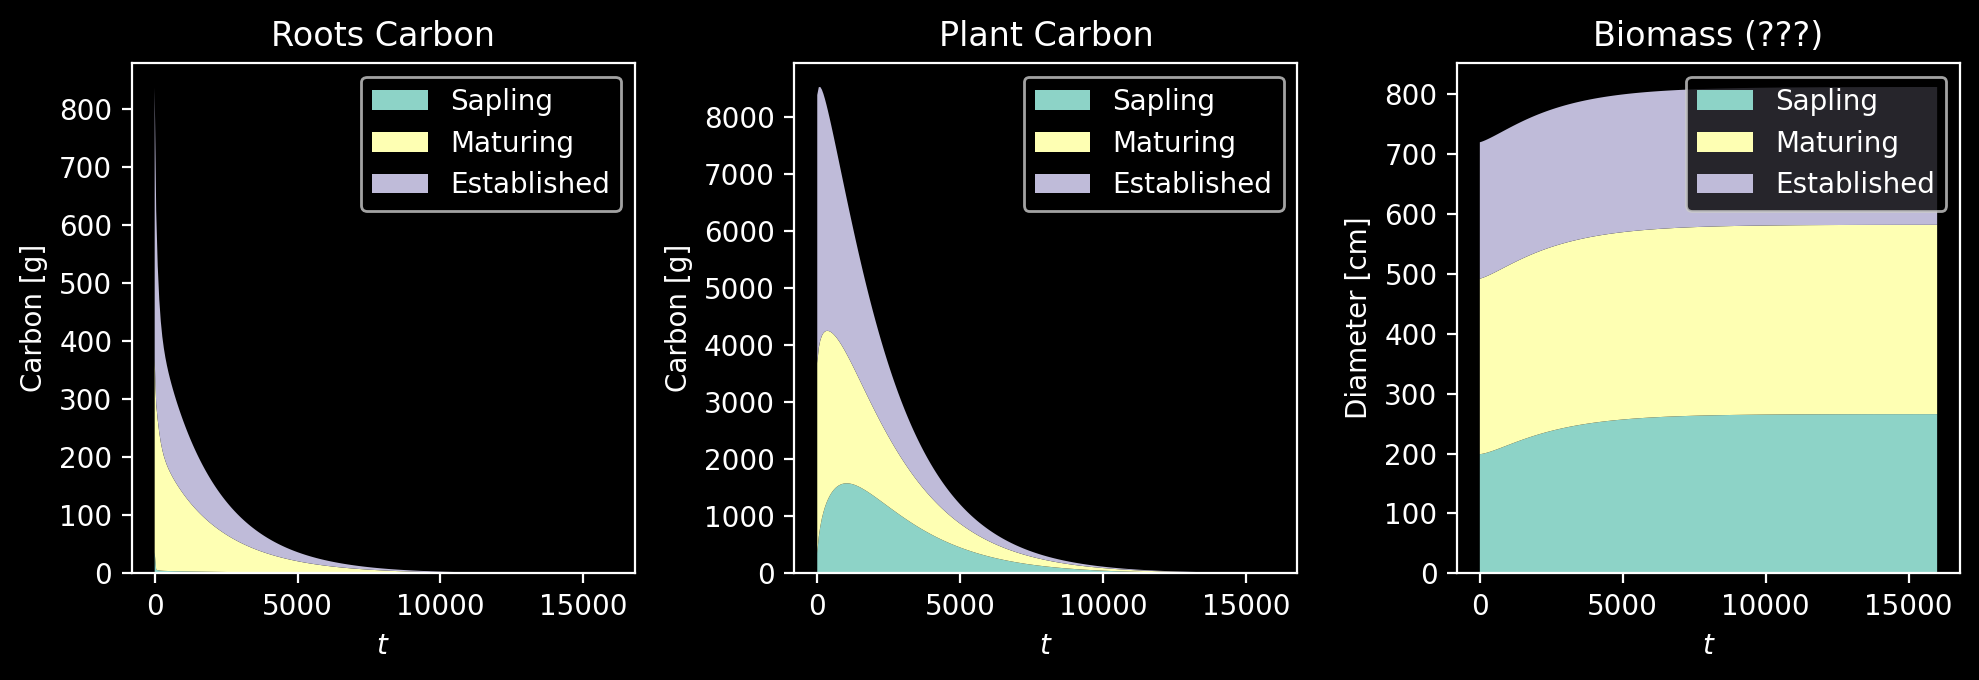

In [84]:
roots_carbon_per_cohort = {}
plant_carbon_per_cohort = {}
plant_diameter_per_cohort = {}


for cohort, nodes in nodes_by_cohort.items():
    
    node_idxs = [node_list.index(node) for node in nodes]
    
    #not sure if total diameter makes sense, but currently included to show growth. 
    total_diameter = np.sum(plant_diameter[node_idxs, :], axis = 0)
    total_plant_carbon = np.sum(plant_carbon[node_idxs, :], axis = 0)
    totaL_root_carbon  = np.sum(roots_carbon[node_idxs, :], axis = 0)
    
    roots_carbon_per_cohort[cohort] = totaL_root_carbon
    plant_carbon_per_cohort[cohort] = total_plant_carbon
    plant_diameter_per_cohort[cohort] = total_diameter
    

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 3.5), dpi=200)

axes[0].set_title("Roots Carbon")
axes[0].stackplot(t, np.array(list(roots_carbon_per_cohort.values())))
axes[0].legend(labels = np.array(list(roots_carbon_per_cohort.keys())))
axes[0].set_ylabel("Carbon [g]")
axes[0].set_xlabel("$t$")


axes[1].set_title("Plant Carbon")
axes[1].stackplot(t, np.array(list(plant_carbon_per_cohort.values())))
axes[1].legend(labels = np.array(list(plant_carbon_per_cohort.keys())))
axes[1].set_ylabel("Carbon [g]")
axes[1].set_xlabel("$t$")


axes[2].set_title("Biomass (???)")
axes[2].stackplot(t, np.array(list(plant_diameter_per_cohort.values())))
axes[2].legend(labels = np.array(list(plant_diameter_per_cohort.keys())))
axes[2].set_ylabel("Diameter [cm]")
axes[2].set_xlabel("$t$")

 
plt.tight_layout()
plt.show()

### Growth Statistics

In [85]:
from experiments import run_graph_type_experiments

# data = run_graph_type_experiments(n_max=100)

# # results of the above functions are loaded by:
data = np.load("initial_analysis_data.npz", allow_pickle=True)["data"]

ImportError: cannot import name 'generate_random_regular_graph' from 'forest_generator' (/Users/maurits/code/cls/css/mycorrhizal-networks-comlexity-science/forest_generator.py)

In [ ]:
data[()]["ba"]["experiments"][0].keys()

dict_keys(['stats', 'analysis', 'sim_data'])

#### growth depending on degree ($k$)

#### growth depending on diameter size ($d$)

### Sapling Success 

### Sapling Competition 